/var/folders/nt/5pd9877s5lx6vwzd5f15jz7r0000gn/T/ipykernel_10935/3322499191.py:130: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_data_numeric = heatmap_data.replace({"YES": 1, "NO": 0})


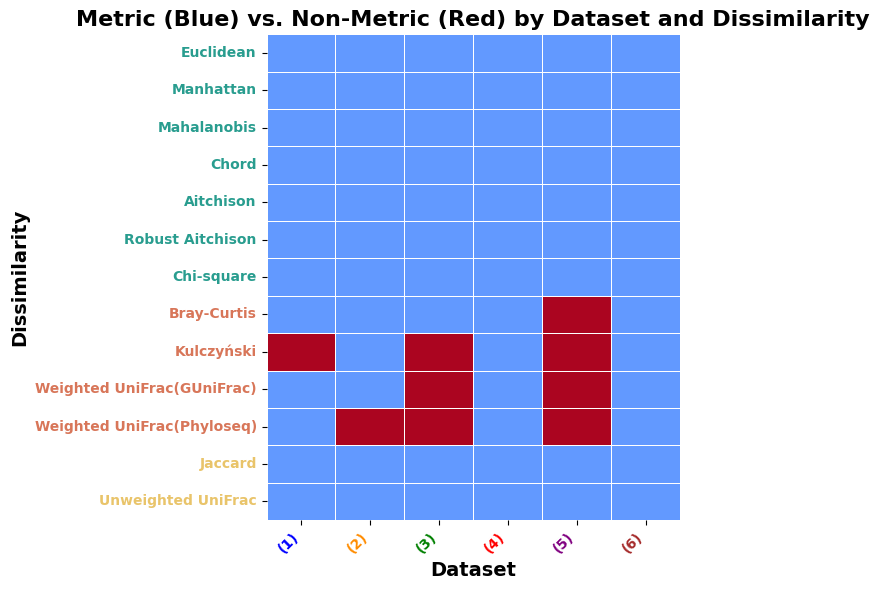

In [ ]:
#!/usr/bin/env python3
"""
make_heatmap.py

- Reads Combined_result_table.csv
- Maps dissimilarities from the CSV to canonical names
- Excludes IBD_wgs
- Rows = dissimilarities (3 category groups)
- Columns = sources (6 dataset categories)
- We rename the x-axis labels so each source just shows "(1)", "(2)", etc.
- "YES" => green cell; "NO" => red cell
"""

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# -----------------------------------------------------------------------------
# 1) Map raw CSV dissimilarity names to canonical names
# -----------------------------------------------------------------------------
name_map = {
    "euclidean":                    "Euclidean",
    "manhattan":                    "Manhattan",
    "mahalanobis":                  "Mahalanobis",
    "chord":                        "Chord",
    "aitchison":                    "Aitchison",
    "robust.aitchison":             "Robust Aitchison",
    "chisq":                        "Chi-square",
    "bray":                         "Bray-Curtis",
    "kulczynski":                   "Kulczyński",
    "unifrac_weighted_gunifrac":    "Weighted UniFrac(GUniFrac)",
    "unifrac_weighted_phyloseq":    "Weighted UniFrac(Phyloseq)",
    "unifrac_unweighted":           "Unweighted UniFrac",
    "jaccard":                      "Jaccard"
}

# -----------------------------------------------------------------------------
# 2) Define canonical dissimilarities and categories for the rows
# -----------------------------------------------------------------------------
category1 = [
    "Euclidean", 
    "Manhattan", 
    "Mahalanobis", 
    "Chord", 
    "Aitchison", 
    "Robust Aitchison", 
    "Chi-square"
]
category2 = [
    "Bray-Curtis",
    "Kulczyński",
    "Weighted UniFrac(GUniFrac)",
    "Weighted UniFrac(Phyloseq)"
]
category3 = [
    "Jaccard",
    "Unweighted UniFrac"
]

dissimilarity_order = category1 + category2 + category3

dissim2cat = {}
for d in category1:
    dissim2cat[d] = 1
for d in category2:
    dissim2cat[d] = 2
for d in category3:
    dissim2cat[d] = 3

# -----------------------------------------------------------------------------
# 3) Define the sources we keep & exclude "IBD_wgs"
# -----------------------------------------------------------------------------
source_category_map = {
    "cardiovascular":         1,
    "covid":                  2,
    "IBD_16s":                3,
    "Pig_gut":                4,
    "Concordance_oral_16S":   5,
    "HIV_gut":                6
}
source_order = list(source_category_map.keys())  # => [cardiovascular, covid, IBD_16s, ...]

source_label_map = {
    "cardiovascular":         "(1)",
    "covid":                  "(2)",
    "IBD_16s":                "(3)",
    "Pig_gut":                "(4)",
    "Concordance_oral_16S":   "(5)",
    "HIV_gut":                "(6)"
}

x_tick_color_map = {
    "(1)": "blue",
    "(2)": "darkorange",
    "(3)": "green",
    "(4)": "red",
    "(5)": "purple",
    "(6)": "brown"
}

# -----------------------------------------------------------------------------
# 4) Load CSV and keep only IsMetric, source, Dissimilarity
# -----------------------------------------------------------------------------
df = pd.read_csv(
    "Combined_result_table.csv",
    usecols=["IsMetric", "source", "Dissimilarity"]
)

# 5) Exclude rows where source == "IBD_wgs"
df = df[df["source"] != "IBD_wgs"].copy()

# 6) Map raw dissimilarities to canonical & filter
df["Dissimilarity_Canonical"] = df["Dissimilarity"].replace(name_map)
df = df[df["Dissimilarity_Canonical"].isin(dissimilarity_order)].copy()
df = df[df["source"].isin(source_order)].copy()

# 7) Pivot
heatmap_data = df.pivot(
    index="Dissimilarity_Canonical",
    columns="source",
    values="IsMetric"
)
heatmap_data = heatmap_data.reindex(
    index=dissimilarity_order,
    columns=source_order
)

# 8) Convert YES/NO => 1/0 for coloring
heatmap_data_numeric = heatmap_data.replace({"YES": 1, "NO": 0})

# 9) 2-color colormap: 0=red, 1=green  (adjust if you want your own custom colors)
cmap = mcolors.ListedColormap(["#AB0520", "#6299FF"])

# 10) Row label colors
row_label_colors = {
    1: "#299D8F",
    2: "#D87659",
    3: "#E9C46A"
}

# 11) Plot
plt.figure(figsize=(7, 6))

ax = sns.heatmap(
    heatmap_data_numeric,
    cmap=cmap,
    cbar=False,
    linewidths=0.5,
    linecolor="white"
)

# 12) Color y-tick labels by category
for tick_label in ax.get_yticklabels():
    label_text = tick_label.get_text()
    cat = dissim2cat.get(label_text, None)
    if cat is not None:
        tick_label.set_color(row_label_colors[cat])
        tick_label.set_fontweight("bold")
    else:
        tick_label.set_color("black")

# 13) Customize x‐axis labels to show "(1)", "(2)", etc. & color them
current_xlabels = ax.get_xticklabels()
new_ticklabels = []
for lbl in current_xlabels:
    original_source = lbl.get_text()
    short_label     = source_label_map.get(original_source, original_source)
    new_ticklabels.append(short_label)

ax.set_xticklabels(new_ticklabels,fontweight='bold')

for tick_label in ax.get_xticklabels():
    short_lbl = tick_label.get_text()
    color_val = x_tick_color_map.get(short_lbl, "black")
    tick_label.set_color(color_val)

# NEW: Set axis labels
ax.set_xlabel("Dataset", fontsize=14, fontweight="bold")
ax.set_ylabel("Dissimilarity", fontsize=14, fontweight="bold")

plt.xticks(rotation=45, ha="right")
plt.title("Metric (Blue) vs. Non-Metric (Red) by Dataset and Dissimilarity", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.savefig("heatmap_metric_vs_nonmetric.eps", format="eps", dpi=600, bbox_inches="tight")
plt.show()



=== Preview of FNI (PcoaNegFrac) by Dataset and Dissimilarity ===
              source    Dissimilarity_Canonical  PcoaNegFrac
      cardiovascular                  Euclidean     0.000000
               covid                  Euclidean     0.000000
             IBD_16s                  Euclidean     0.000000
             Pig_gut                  Euclidean     0.000000
Concordance_oral_16S                  Euclidean     0.000000
             HIV_gut                  Euclidean     0.000000
      cardiovascular                  Manhattan    12.058666
               covid                  Manhattan     2.135734
             IBD_16s                  Manhattan     8.611300
             Pig_gut                  Manhattan     3.376877
Concordance_oral_16S                  Manhattan    12.778984
             HIV_gut                  Manhattan     4.410497
               covid                Mahalanobis     0.000000
             IBD_16s                Mahalanobis     0.000000
             Pig_g

/var/folders/nt/5pd9877s5lx6vwzd5f15jz7r0000gn/T/ipykernel_5159/3729430471.py:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bubble.set_xticklabels([source_label_map[src] for src in source_order], fontsize=12, fontweight='bold')
/var/folders/nt/5pd9877s5lx6vwzd5f15jz7r0000gn/T/ipykernel_5159/3729430471.py:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bubble.set_yticklabels(dissimilarity_order, fontsize=12, fontweight='bold')


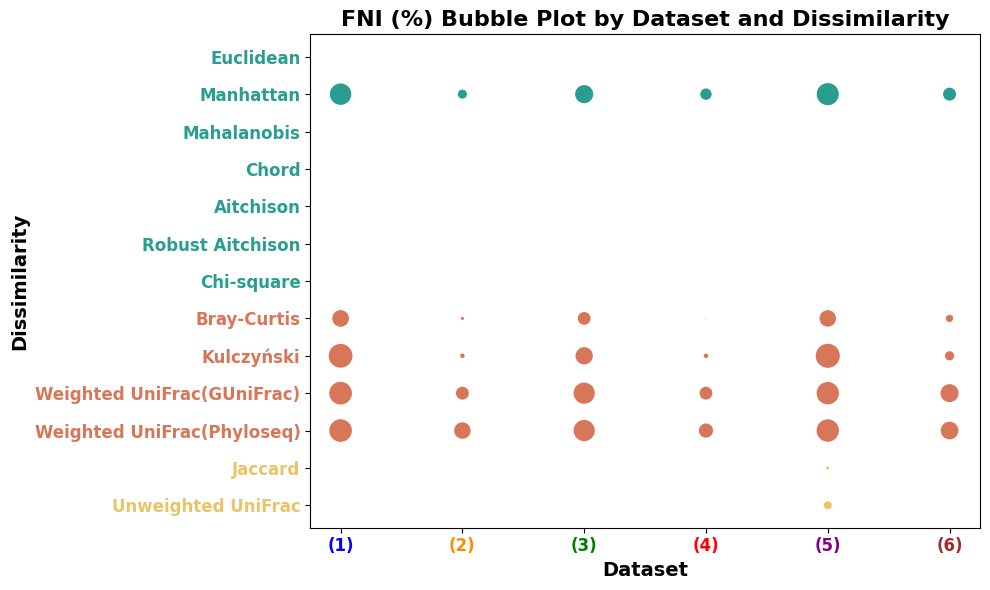

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("Combined_result_table.csv", usecols=["source", "Dissimilarity", "PcoaNegFrac"])

# Map dissimilarity to canonical names
name_map = {
    "euclidean": "Euclidean",
    "manhattan": "Manhattan",
    "mahalanobis": "Mahalanobis",
    "chord": "Chord",
    "aitchison": "Aitchison",
    "robust.aitchison": "Robust Aitchison",
    "chisq": "Chi-square",
    "bray": "Bray-Curtis",
    "kulczynski": "Kulczyński",
    "unifrac_weighted_gunifrac": "Weighted UniFrac(GUniFrac)",
    "unifrac_weighted_phyloseq": "Weighted UniFrac(Phyloseq)",
    "unifrac_unweighted": "Unweighted UniFrac",
    "jaccard": "Jaccard"
}

dissimilarity_order = [
    "Euclidean", "Manhattan", "Mahalanobis", "Chord",
    "Aitchison", "Robust Aitchison", "Chi-square",
    "Bray-Curtis", "Kulczyński", "Weighted UniFrac(GUniFrac)",
    "Weighted UniFrac(Phyloseq)", "Jaccard", "Unweighted UniFrac"
]

source_order = [
    "cardiovascular", "covid", "IBD_16s", "Pig_gut", "Concordance_oral_16S", "HIV_gut"
]

source_label_map = {
    "cardiovascular": "(1)",
    "covid": "(2)",
    "IBD_16s": "(3)",
    "Pig_gut": "(4)",
    "Concordance_oral_16S": "(5)",
    "HIV_gut": "(6)"
}

x_tick_color_map = {
    "(1)": "blue",
    "(2)": "darkorange",
    "(3)": "green",
    "(4)": "red",
    "(5)": "purple",
    "(6)": "brown"
}

row_label_colors = {
    "Euclidean": "#299D8F",
    "Manhattan": "#299D8F",
    "Mahalanobis": "#299D8F",
    "Chord": "#299D8F",
    "Aitchison": "#299D8F",
    "Robust Aitchison": "#299D8F",
    "Chi-square": "#299D8F",
    "Bray-Curtis": "#D87659",
    "Kulczyński": "#D87659",
    "Weighted UniFrac(GUniFrac)": "#D87659",
    "Weighted UniFrac(Phyloseq)": "#D87659",
    "Jaccard": "#E9C46A",
    "Unweighted UniFrac": "#E9C46A"
}

# Preprocessing
df = df[df["source"].isin(source_order)].copy()
df["Dissimilarity_Canonical"] = df["Dissimilarity"].replace(name_map)
df = df[df["Dissimilarity_Canonical"].isin(dissimilarity_order)].copy()

# ✅ Strip '%' and convert to float
df["PcoaNegFrac"] = df["PcoaNegFrac"].str.rstrip('%').astype(float)

# Map labels and order
df["source_label"] = df["source"].map(source_label_map)
df["Dissimilarity_Canonical"] = pd.Categorical(df["Dissimilarity_Canonical"], categories=dissimilarity_order, ordered=True)
df["source"] = pd.Categorical(df["source"], categories=source_order, ordered=True)

# Optional print preview
print("\n=== Preview of FNI (PcoaNegFrac) by Dataset and Dissimilarity ===")
print(
    df[["source", "Dissimilarity_Canonical", "PcoaNegFrac"]]
    .sort_values(["Dissimilarity_Canonical", "source"])
    .to_string(index=False)
)

# Plot
plt.figure(figsize=(10, 6))
bubble = sns.scatterplot(
    data=df,
    x="source",
    y="Dissimilarity_Canonical",
    size="PcoaNegFrac",
    sizes=(0, 300),  # ✅ 0% = no bubble, high % = large bubble
    legend=False,
    hue="Dissimilarity_Canonical",
    palette=row_label_colors,
    marker="o",
    alpha=1.0
)

# Format ticks
bubble.set_xticklabels([source_label_map[src] for src in source_order], fontsize=12, fontweight='bold')
bubble.set_yticklabels(dissimilarity_order, fontsize=12, fontweight='bold')

# Color x-tick labels
for tick_label in bubble.get_xticklabels():
    short_lbl = tick_label.get_text()
    tick_label.set_color(x_tick_color_map.get(short_lbl, "black"))

# Color y-tick labels
for tick_label in bubble.get_yticklabels():
    label_text = tick_label.get_text()
    tick_label.set_color(row_label_colors.get(label_text, "black"))

# Labels and title
plt.xlabel("Dataset", fontsize=14, fontweight="bold")
plt.ylabel("Dissimilarity", fontsize=14, fontweight="bold")
plt.title("FNI (%) Bubble Plot by Dataset and Dissimilarity", fontsize=16, fontweight="bold")

# Save and show
plt.tight_layout()
plt.savefig("bubble_plot_fni_colored.eps", format="eps", dpi=600, bbox_inches="tight")
plt.show()


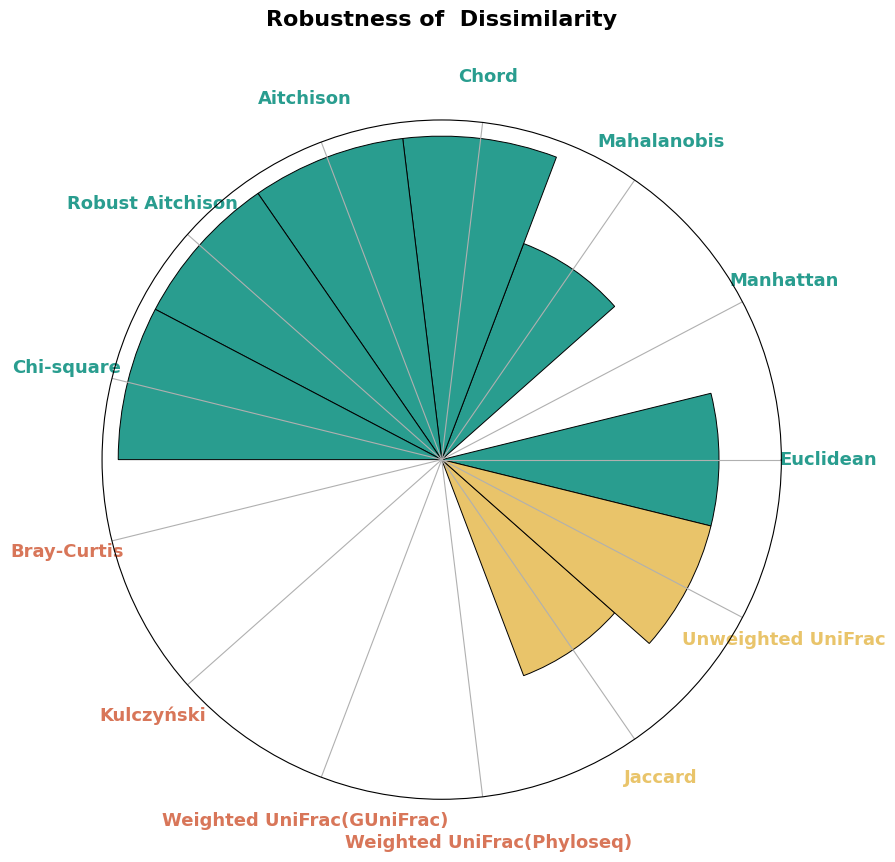

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load CSV
df = pd.read_csv("Combined_result_table.csv", usecols=["source", "Dissimilarity", "PcoaNegFrac"])

# Map raw to canonical names
name_map = {
    "euclidean": "Euclidean",
    "manhattan": "Manhattan",
    "mahalanobis": "Mahalanobis",
    "chord": "Chord",
    "aitchison": "Aitchison",
    "robust.aitchison": "Robust Aitchison",
    "chisq": "Chi-square",
    "bray": "Bray-Curtis",
    "kulczynski": "Kulczyński",
    "unifrac_weighted_gunifrac": "Weighted UniFrac(GUniFrac)",
    "unifrac_weighted_phyloseq": "Weighted UniFrac(Phyloseq)",
    "unifrac_unweighted": "Unweighted UniFrac",
    "jaccard": "Jaccard"
}

# Define category color mapping
row_label_colors = {
    "Euclidean": "#299D8F",
    "Manhattan": "#299D8F",
    "Mahalanobis": "#299D8F",
    "Chord": "#299D8F",
    "Aitchison": "#299D8F",
    "Robust Aitchison": "#299D8F",
    "Chi-square": "#299D8F",
    "Bray-Curtis": "#D87659",
    "Kulczyński": "#D87659",
    "Weighted UniFrac(GUniFrac)": "#D87659",
    "Weighted UniFrac(Phyloseq)": "#D87659",
    "Jaccard": "#E9C46A",
    "Unweighted UniFrac": "#E9C46A"
}

# Define order of appearance
dissimilarity_order = list(row_label_colors.keys())

# Canonical mapping and filter
df["Dissimilarity_Canonical"] = df["Dissimilarity"].replace(name_map)
df = df[df["Dissimilarity_Canonical"].isin(dissimilarity_order)].copy()

# Convert % to float
df["PcoaNegFrac"] = df["PcoaNegFrac"].str.rstrip('%').astype(float)

# Count FNI == 0 by dissimilarity
fni_zero_counts = (
    df[df["PcoaNegFrac"] == 0]
    .groupby("Dissimilarity_Canonical")
    .size()
    .reindex(dissimilarity_order)
    .fillna(0)
)

# Prepare angles and data
angles = np.linspace(0, 2 * np.pi, len(fni_zero_counts), endpoint=False).tolist()
counts = fni_zero_counts.tolist()
colors = [row_label_colors[d] for d in dissimilarity_order]

# Create polar plot
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))
bars = ax.bar(
    angles,
    counts,
    width=2 * np.pi / len(counts),
    color=colors,
    edgecolor='black',
    linewidth=0.7
)

# Set custom x-tick positions and properties
ax.set_xticks(angles)
ax.set_xticklabels(dissimilarity_order, fontsize=13, fontweight="bold")

# Push labels outward by increasing radius using set_position
for tick, angle, label in zip(ax.xaxis.get_major_ticks(), angles, dissimilarity_order):
    tick_label = tick.label1
    tick_label.set_color(row_label_colors[label])
    tick_label.set_fontweight("bold")
    tick_label.set_fontsize(13)
    tick_label.set_horizontalalignment("center")
    tick.set_pad(23)  # Increase distance from center

# Hide radial tick marks
ax.set_yticklabels([])
ax.set_yticks([])

# Title
ax.set_title("Robustness of  Dissimilarity", fontsize=16, fontweight="bold", pad=30)

# Save (optional)
# plt.savefig("rose_diagram_fni_zero_counts.eps", format="eps", dpi=600, bbox_inches="tight")

plt.tight_layout()
plt.savefig("rose_diagram_fni_zero_counts.eps", format="eps", dpi=600, bbox_inches="tight")
plt.show()
